# Capstone Project Notebook -Clustering stations in the Italian region of Lazio
### IBM Data Scientist Certified Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Business Problem](#businessproblem)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction<a name="introduction"></a>

This project is a "Capstone Project" of Coursera - "IBM Certified Data Scientist" program.
The project is focused on the railway stations located in the Italian region of Lazio, a territory populated by 5.9 million people, visited by more than 12 million tourists each year and served by 165 train stations (41 of them inside the city of Rome).
Rete Ferroviaria Italiana is the owner of the stations, and classifies them as “bronze”, “silver”, “gold” and “platinum”, depending on the services offered at the venue, to both travelers and non-travelers.
Goal of the project is to use data gathered from Foursquare and other sources to classify the stations independently and understand if some stations should deserve a different status, according to the characteristics of the nearby area.

## Business Problem <a name="businessproblem"></a>

RFI train stations underwent a significant transformation, from travel hubs to meeting centers and places of aggregation, going beyond their original role of serving travelers by offering diverse services to travelers and non-travelers as well, such as catering services, parking places, retail stores, coworking places and more.
The service offering of a station depends on its class, that goes from “bronze” to “silver”, “gold” and “platinum”.
Goal of this study is to use open data about the 165 train stations in the Italian region of Lazio to categorize them depending on a series of factors, such as the number of check-ins and reviews, and characteristics of the nearby area such as traffic and population, and the number of significant venues in a radius of 1 km from the station, such as number of restaurants, museums, universities, cafes, professional buildings, hotels, shops, gyms and more.
This categorization will be useful to compare the current classification made by RFI with the one deriving from the above parameters, to understand if some station should deserve a different status, such as a promotion or a demotion.
The main target audience will be, therefore, RFI management. 

## Data <a name="data"></a>

The table below reports the type of data needed and their sources.

| Data | Source | Last updated |
| --- | --- | --- |
| List of RFI train stations in the Lazio region, with location and classification | http://www.rfi.it/rfi/LINEE-STAZIONI-TERRITORIO/Nelle-regioni/Lazio | 2019 |
| Number of check-ins and reviews of each station | FourSquare API | Daily updates |
| Top 100 venues in a 1000 meters range of each station, categorized by high-level groups | FourSquare API | Daily updates |
| Population and density of the neighborhoods hosting the stations, inside Rome | https://it.wikipedia.org/wiki/Municipi_di_Roma | 2017 |
| Population and density of the neighborhoods hosting the stations, outside Rome | https://www.tuttitalia.it/lazio/27-comuni/popolazione/ | 2019 |
| Pollution levels (as a rough indicator of traffic) | http://www.arpalazio.net/main/aria/sci/qa/misure/PM10.php | 2019 |

### Necessary imports and installations

In [1]:
# installing geocoder, geopy and folium
!pip3 install geocoder --user
!pip3 install geopy --user
!pip3 install folium --user

# importing pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# importing requests for web page retrieval
import requests

# importing Beautiful soup for web page parsing
from bs4 import BeautifulSoup as BS

# importing matplotlib for map colors
import matplotlib.cm as cm
import matplotlib.colors as colors

# importing math for NaN processing
import math

# importing geocoder, Nominatim and folium for map generation
import geocoder 
from geopy.geocoders import Nominatim 
import folium

# importing KMeans for clustering
from sklearn.cluster import KMeans

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [163]:
# installing xlwt for excel export
!pip3 install xlwt

     |████████████████████████████████| 102kB 770kB/s ta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


### Loading Data

Loading the stations from the web page

In [137]:
#loading stations from the web page

# source url
url = "http://www.rfi.it/rfi/LINEE-STAZIONI-TERRITORIO/Nelle-regioni/Lazio"

# performing the request
file = requests.get(url).text

Parsing the text with BeautifulSoup to retrieve the table

In [138]:
# parsing data with Beautiful Soup
parsable_file = BS(file, 'lxml')

# retrieving the table
data_table_list = parsable_file.find_all('table')
data_table = data_table_list[1]

Converting the table into a list

In [139]:
# converting the table into a list
list = pd.read_html(str(data_table), header=0)
list

[                   ultimo aggiornamento: 22 marzo 2019  \
 0                                           STAZONI(*)   
 1                                Nome Stazione/fermata   
 2                                        ACQUA ACETOSA   
 3                                       ALBANO LAZIALE   
 4                                        ANAGNI-FIUGGI   
 5                                           ANGUILLARA   
 6                                     ANTRODOCO CENTRO   
 7                               ANTRODOCO-BORGO VELINO   
 8                                                ANZIO   
 9                                        ANZIO COLONIA   
 10                              APPIANO PROBA PETRONIA   
 11                                             APRILIA   
 12                                                ARCE   
 13                                              ARPINO   
 14                                              ARSOLI   
 15                                     BAGNI DI TIVOLI 

Converting the list into a dataframe

In [140]:
# converting the list into a dataframe
df_stations = list[0]
df_stations.head(200)

,ultimo aggiornamento: 22 marzo 2019,ultimo aggiornamento: 22 marzo 2019.1,ultimo aggiornamento: 22 marzo 2019.2,ultimo aggiornamento: 22 marzo 2019.3,ultimo aggiornamento: 22 marzo 2019.4,ultimo aggiornamento: 22 marzo 2019.5
0,STAZONI(*),STAZONI(*),STAZONI(*),STAZONI(*),STAZONI(*),STAZONI(*)
1,Nome Stazione/fermata,Indirizzo,Comune/Località,Provincia,Network,Categoria
2,ACQUA ACETOSA,VIA DELL'ACQUA ACETOSA,CIAMPINO,RM,RFI,BRONZE
3,ALBANO LAZIALE,"VIALE EUROPA, 5",ALBANO LAZIALE,RM,RFI (600s),SILVER
4,ANAGNI-FIUGGI,VIA DELLO SCALO FERROVIARIO,ANAGNI,FR,RFI (600s),SILVER
5,ANGUILLARA,VIA DELLA STAZIONE,ANGUILLARA,RM,RFI (600s),SILVER
6,ANTRODOCO CENTRO,VIALE DELLA STAZIONE,ANTRODOCO,RI,RFI,BRONZE
7,ANTRODOCO-BORGO VELINO,PIAZZA MARCONI,ANTRODOCO,RI,RFI,BRONZE
8,ANZIO,PIAZZA R. PALOMBA,ANZIO,RM,RFI (600s),SILVER
9,ANZIO COLONIA,VIA VASCO DE GAMA,ANZIO,RM,RFI (600s),BRONZE


Dropping useless rows and columns and giving the dataframe its final shape

In [141]:
# dropping the row with useless repetitions (STAZIONI(*))
df_stations = df_stations.drop([0])
df_stations = df_stations.drop([167])

# setting the proper row as column headers (Nome stazione/Fermata...)
df_stations.columns = df_stations.iloc[0]

# dropping the duplicate header
df_stations = df_stations.drop([1])

df_stations.head(200)

1,Nome Stazione/fermata,Indirizzo,Comune/Località,Provincia,Network,Categoria
2,ACQUA ACETOSA,VIA DELL'ACQUA ACETOSA,CIAMPINO,RM,RFI,BRONZE
3,ALBANO LAZIALE,"VIALE EUROPA, 5",ALBANO LAZIALE,RM,RFI (600s),SILVER
4,ANAGNI-FIUGGI,VIA DELLO SCALO FERROVIARIO,ANAGNI,FR,RFI (600s),SILVER
5,ANGUILLARA,VIA DELLA STAZIONE,ANGUILLARA,RM,RFI (600s),SILVER
6,ANTRODOCO CENTRO,VIALE DELLA STAZIONE,ANTRODOCO,RI,RFI,BRONZE
7,ANTRODOCO-BORGO VELINO,PIAZZA MARCONI,ANTRODOCO,RI,RFI,BRONZE
8,ANZIO,PIAZZA R. PALOMBA,ANZIO,RM,RFI (600s),SILVER
9,ANZIO COLONIA,VIA VASCO DE GAMA,ANZIO,RM,RFI (600s),BRONZE
10,APPIANO PROBA PETRONIA,VIA APPIANO E VIA P. PETRONIA,ROMA,RM,RFI (600s),SILVER
11,APRILIA,PIAZZA F. SADA - VIA DELLA STAZIONE,APRILIA,LT,RFI (600s),SILVER


In [142]:
# dropping the column reporting the company managing the station
df_stations = df_stations.drop('Network', axis=1)
df_stations.head()

1,Nome Stazione/fermata,Indirizzo,Comune/Località,Provincia,Categoria
2,ACQUA ACETOSA,VIA DELL'ACQUA ACETOSA,CIAMPINO,RM,BRONZE
3,ALBANO LAZIALE,"VIALE EUROPA, 5",ALBANO LAZIALE,RM,SILVER
4,ANAGNI-FIUGGI,VIA DELLO SCALO FERROVIARIO,ANAGNI,FR,SILVER
5,ANGUILLARA,VIA DELLA STAZIONE,ANGUILLARA,RM,SILVER
6,ANTRODOCO CENTRO,VIALE DELLA STAZIONE,ANTRODOCO,RI,BRONZE


In [164]:
# saving stations to excel
df_stations.to_excel(r'stations.xls')

Loading Rome neighbourhoods from the webpage

In [144]:
#loading neighbourhoods from the web page

# source url
url_neigh = "https://it.wikipedia.org/wiki/Municipi_di_Roma"

# performing the request
file_neigh = requests.get(url_neigh).text

Parsing the text with BeautifulSoup to retrieve the table

In [145]:
# parsing data with Beautiful Soup
parsable_file = BS(file_neigh, 'lxml')

# retrieving the table
data_table_list = parsable_file.find_all('table')
data_table = data_table_list[0]

Converting the table into a list

In [146]:
# converting the table into a list
list = pd.read_html(str(data_table), header=0)
list

[                       Municipio di Roma Popolazione(ab) Superficie(km²)  \
 0                       I Centro Storico         186 802             199   
 1                   II Parioli/Nomentano         167 736             196   
 2                        III Monte Sacro         204 514             978   
 3                           IV Tiburtina         177 084             491   
 4                V Prenestino/Centocelle         246 471             270   
 5                    VI Roma delle Torri         256 261            1134   
 6   VII Appio-Latino/Tuscolana/Cinecittà         307 607             468   
 7                      VIII Appia Antica         131 082             473   
 8                                 IX Eur         180 511            1831   
 9                         X Ostia/Acilia         230 544            1506   
 10                  XI Arvalia/Portuense         154 871             709   
 11                       XII Monte Verde         140 996             731   

Converting the list into a dataframe

In [147]:
# converting the list into a dataframe
df_rome_neigh = list[0]
df_rome_neigh.head(200)

,Municipio di Roma,Popolazione(ab),Superficie(km²),Densità(ab/km²),Presidente,Corrispondenza con Municipi 2001-2013e Circoscrizioni,Suddivisioni amministrative
0,I Centro Storico,186 802,199,9382,Sabrina Alfonsi (Partito Democratico) [7],"Municipio Roma I, già Circoscrizione IMunicipi...","1A Centro Storico, 1B Trastevere, 1C Aventino,..."
1,II Parioli/Nomentano,167 736,196,8567,Francesca Del Bello (Partito Democratico) [8],"Municipio Roma II, già Circoscrizione IIMunici...","2A Villaggio Olimpico, 2B Parioli, 2C Flaminio..."
2,III Monte Sacro,204 514,978,2091,Giovanni Caudo (centrosinistra) [9],"Municipio Roma IV, già Circoscrizione IV","4A Monte Sacro, 4B Val Melaina, 4C Monte Sacro..."
3,IV Tiburtina,177 084,491,3603,NaN,"Municipio Roma V, già Circoscrizione V",NaN
4,V Prenestino/Centocelle,246 471,270,9137,NaN,"Municipio Roma VI, già Circoscrizione VIMunici...",NaN
5,VI Roma delle Torri,256 261,1134,2261,NaN,"Municipio Roma VIII, già Circoscrizione VIII",NaN
6,VII Appio-Latino/Tuscolana/Cinecittà,307 607,468,6580,NaN,"Municipio Roma IX, già Circoscrizione IXMunici...",NaN
7,VIII Appia Antica,131 082,473,2772,NaN,"Municipio Roma XI, già Circoscrizione XI",NaN
8,IX Eur,180 511,1831,985,NaN,"Municipio Roma XII, già Circoscrizione XII",NaN
9,X Ostia/Acilia,230 544,1506,1530,NaN,"Municipio Roma XIII, già Circoscrizione XIII",NaN


Deleting un-necessary columns

In [148]:
df_rome_neigh = df_rome_neigh.drop(['Superficie(km²)', 'Presidente','Corrispondenza con Municipi 2001-2013e Circoscrizioni', 'Suddivisioni amministrative'], axis = 1)
df_rome_neigh.head()

,Municipio di Roma,Popolazione(ab),Densità(ab/km²)
0,I Centro Storico,186 802,9382
1,II Parioli/Nomentano,167 736,8567
2,III Monte Sacro,204 514,2091
3,IV Tiburtina,177 084,3603
4,V Prenestino/Centocelle,246 471,9137


In [165]:
# saving Rome neighbours to excel
df_rome_neigh.to_excel(r'rome_neighbourhoods.xls')

Loading Lazio neighbourhoods from the webpage

In [150]:
#loading Lazio neighbourhoods (municipi) from the web page

# source url
url_munic = "https://www.tuttitalia.it/lazio/27-comuni/popolazione/"

# performing the request
file_munic = requests.get(url_munic).text

Parsing the text with BeautifulSoup to retrieve the table

In [151]:
# parsing data with Beautiful Soup
parsable_file = BS(file_munic, 'lxml')

# retrieving the table
data_table_list = parsable_file.find_all('table')
data_table = data_table_list[0]

Converting the table into a list

In [152]:
# converting the table into a list
list = pd.read_html(str(data_table), header=0)
list

[    Unnamed: 0                    Comune Popolazioneresidenti Superficiekm²  \
 0           1.                    RMROMA            2.856.133       1.28736   
 1           2.                  LTLATINA              126.746         27762   
 2           3.     RMGuidonia Montecelio               89.671          7947   
 3           4.               RMFiumicino               80.470         21389   
 4           5.                 LTAprilia               74.660         17811   
 5           6.                 VTVITERBO               67.681         40623   
 6           7.                 RMPomezia               63.792          8657   
 7           8.                  RMTivoli               56.472          6865   
 8           9.                   RMAnzio               55.101          4365   
 9          10.                RMVelletri               53.250         11823   
 10         11.           RMCivitavecchia               52.716          7374   
 11         12.                 RMNettun

Converting the list into a dataframe

In [153]:
# converting the list into a dataframe
df_rome_munic = list[0]
df_rome_munic.head(200)

,Unnamed: 0,Comune,Popolazioneresidenti,Superficiekm²,Densitàabitanti/km²,Altitudinem s.l.m.
0,1.,RMROMA,2.856.133,1.28736,2.219,20
1,2.,LTLATINA,126.746,27762,457,21
2,3.,RMGuidonia Montecelio,89.671,7947,1.128,105
3,4.,RMFiumicino,80.470,21389,376,1
4,5.,LTAprilia,74.660,17811,419,80
5,6.,VTVITERBO,67.681,40623,167,326
6,7.,RMPomezia,63.792,8657,737,108
7,8.,RMTivoli,56.472,6865,823,235
8,9.,RMAnzio,55.101,4365,1.262,3
9,10.,RMVelletri,53.250,11823,450,372


Deleting un-necessary columns/rows and fixing province/city mixed up error

In [154]:
# dropping un-necessary columns
df_rome_munic = df_rome_munic.drop(['Unnamed: 0', 'Superficiekm²','Altitudinem s.l.m.'], axis = 1)
df_rome_munic.head()

,Comune,Popolazioneresidenti,Densitàabitanti/km²
0,RMROMA,2.856.133,2.219
1,LTLATINA,126.746,457
2,RMGuidonia Montecelio,89.671,1.128
3,RMFiumicino,80.470,376
4,LTAprilia,74.660,419


In [155]:
# dropping un-necessary rows
df_rome_munic = df_rome_munic[:50]
df_rome_munic.head(60)

,Comune,Popolazioneresidenti,Densitàabitanti/km²
0,RMROMA,2.856.133,2.219
1,LTLATINA,126.746,457
2,RMGuidonia Montecelio,89.671,1.128
3,RMFiumicino,80.470,376
4,LTAprilia,74.660,419
5,VTVITERBO,67.681,167
6,RMPomezia,63.792,737
7,RMTivoli,56.472,823
8,RMAnzio,55.101,1.262
9,RMVelletri,53.250,450


In [156]:
def split_first_two(field):
    field = field[0:2]
    return field

def split_last_two(field):
    field = field[2:]
    return field


df_rome_munic['Provincia'] = df_rome_munic['Comune'].apply(split_first_two)
df_rome_munic['Comune'] = df_rome_munic['Comune'].apply(split_last_two)
df_rome_munic.head(50)

,Comune,Popolazioneresidenti,Densitàabitanti/km²,Provincia
0,ROMA,2.856.133,2.219,RM
1,LATINA,126.746,457,LT
2,Guidonia Montecelio,89.671,1.128,RM
3,Fiumicino,80.470,376,RM
4,Aprilia,74.660,419,LT
5,VITERBO,67.681,167,VT
6,Pomezia,63.792,737,RM
7,Tivoli,56.472,823,RM
8,Anzio,55.101,1.262,RM
9,Velletri,53.250,450,RM


Saving Lazio neighbours to Excel

In [166]:
# saving Lazio neighbours to excel
df_rome_munic.to_excel(r'lazio_neighbourhoods.xls')

Loading pollution from the excel

In [158]:
#loading pollutions from the excel

# source filepath
filepath = "lazio_poll.xls"

# populating the dataframe
df_poll = pd.read_excel(filepath)

df_poll.head(50)

,Provincia,Centralina,PM10 agosto,PM10 media,Sforamenti
0,Frosinone,Alatri,22,23,12
1,Frosinone,Anagni,22,20,3
2,Frosinone,Cassino,29,33,38
3,Frosinone,Ceccano,21,37,51
4,Frosinone,Ferentino,26,28,19
5,Frosinone,Fontechiari,19,17,2
6,Frosinone,Frosinone scalo,16,36,44
7,Frosinone,Via Mazzini,27,25,17
8,Latina,Aprilia 2,24,25,8
9,Latina,Latina Scalo,23,23,4


Dropping the un-necessary columns

In [159]:
df_poll = df_poll.drop(['PM10 agosto'], axis = 1)
df_poll.head()

,Provincia,Centralina,PM10 media,Sforamenti
0,Frosinone,Alatri,23,12
1,Frosinone,Anagni,20,3
2,Frosinone,Cassino,33,38
3,Frosinone,Ceccano,37,51
4,Frosinone,Ferentino,28,19


Saving pollutions to Excel

In [255]:
# saving pollutions to excel
df_poll.to_excel(r'lazio_poll.xls')

## Methodology <a name="methodology"></a>

For each station, from the address will be derived the latitude and longitude, and those in turn will be used to retrieve the FourSquare data and venues. The match with population, density and pollution data will be done on the basis of the neighborhood hosting the station, using a closest distance function on longitude and latitude for joining tables.
The above data will be collected in a single dataframe, with a row for each station and columns reporting population, density, pollution and a set of FourSquare categories with the number of top venues occurring for each category.
The features will be standardized for better manipulation of the clustering algorithm, and then a clustering will be performed with 4 clusters, the same number of the classes used by RFI.
The original classes and the new clusters will then be compared, using both tables and maps, to check for correlations between the two.

Loading stations from the excel

In [297]:
#loading stations from the excel

# source filepath
filepath = "stations.xls"

# populating the dataframe
df_stations = pd.read_excel(filepath)

df_stations.head(200)

,Unnamed: 0,Nome Stazione/fermata,Indirizzo,Comune/Località,Provincia,Categoria
0,2,ACQUA ACETOSA,VIA DELL'ACQUA ACETOSA,CIAMPINO,RM,BRONZE
1,3,ALBANO LAZIALE,"VIALE EUROPA, 5",ALBANO LAZIALE,RM,SILVER
2,4,ANAGNI-FIUGGI,VIA STAZIONE ANAGNI MOROLO,ANAGNI,FR,SILVER
3,5,ANGUILLARA,VIA CAMPO MARINARO,ANGUILLARA,RM,SILVER
4,6,ANTRODOCO CENTRO,VIALE DELLA STAZIONE,ANTRODOCO,RI,BRONZE
5,7,ANTRODOCO-BORGO VELINO,VIALE DELLA STAZIONE,ANTRODOCO,RI,BRONZE
6,8,ANZIO,PIAZZA R. PALOMBA,ANZIO,RM,SILVER
7,9,ANZIO COLONIA,VIA VASCO DE GAMA,ANZIO,RM,BRONZE
8,10,APPIANO PROBA PETRONIA,VIA APPIANO,ROMA,RM,SILVER
9,11,APRILIA,PIAZZA F. SADA,APRILIA,LT,SILVER


Retrieving a list containing address (for control), Longitude and Latitude of each train station

In [298]:
# retrieving longitude and latitude of each train station

# instantiating a geolocator
geolocator = Nominatim(user_agent="stat_explorer")
count = 0
# retrieving data for each station
columns_list = []

for address, city, name in zip(df_stations['Indirizzo'], df_stations['Comune/Località'], df_stations['Nome Stazione/fermata']):
    complete_address = address + ',' + city
    # passing the location to the geolocator
    location = geolocator.geocode(complete_address)
    if location is None:
        location = geolocator.geocode(str(name))  
        print('nome '+name)
    else: print('complete_address '+complete_address)
    # retrieving latitude and longitude from the geolocator
    
    
    print(location)
    print(count)
    count = count + 1
    latitude = location.latitude
    longitude = location.longitude
    display_name = location.address
    columns_list.append([latitude, longitude, display_name])

columns_list

complete_address VIA DELL'ACQUA ACETOSA,CIAMPINO
Via Dell'Acqua Acetosa, Ciampino, RM, LAZ, 00118, Italia
0
complete_address VIALE EUROPA, 5,ALBANO LAZIALE
Albano Laziale, Viale Europa, Albano Laziale, RM, LAZ, 00041, Italia
1
complete_address VIA STAZIONE ANAGNI MOROLO,ANAGNI
Anagni, Via Stazione Anagni Morolo, Anagni, FR, LAZ, 03012, Italia
2
complete_address VIA CAMPO MARINARO,ANGUILLARA
Via Campo Marinaro, Anguillara Sabazia, RM, LAZ, 00061, Italia
3
complete_address VIALE DELLA STAZIONE,ANTRODOCO
Via della Stazione (Salaria vecchia), Borgo Velino, RI, LAZ, Italia
4
complete_address VIALE DELLA STAZIONE,ANTRODOCO
Via della Stazione (Salaria vecchia), Borgo Velino, RI, LAZ, Italia
5
complete_address PIAZZA R. PALOMBA,ANZIO
Anzio, Piazza Raffaele Palomba, Anzio, Quartiere Europa, Anzio, RM, LAZ, 00042, Italia
6
complete_address VIA VASCO DE GAMA,ANZIO
Via Vasco De Gama, Anzio, Anzio Colonia, Anzio, RM, LAZ, 00042, Italia
7
complete_address VIA APPIANO,ROMA
Via Appiano, Balduina, Muni

nome MAGLIANA
Magliana, Via della Magliana, Trullo, Municipio Roma XI, Roma, RM, LAZ, 00148, Italia
77
nome MANZIANA-CANALE MONTERANO
Manziana - Canale Monterano, Via Fonte della Dolce, Manziana, RM, LAZ, 00066, Italia
78
complete_address VIA DELLA STAZIONE,MARCELLINA
Via della Stazione, Colle, Marcellina, RM, LAZ, 00019, Italia
79
complete_address VIA DELLA FORNACE,ANZIO
Via della Fornace, Anzio, Falasche, Anzio, RM, LAZ, 00042, Italia
80
nome MARINA DI CERVETERI
Marina di Cerveteri, RM, LAZ, Italia
81
nome MARINO LAZIALE
Marino Laziale, Via Borgo Stazione, Marino, Frattocchie, Marino, RM, LAZ, 00047, Italia
82
nome MINTURNO-SCAURI
Minturno-Scauri, Via Olmello, Minturno, LT, LAZ, 04028, Italia
83
complete_address VIA DELLA STAZIONE,MONTALTO DI CASTRO
Montalto di Castro, Via della Stazione, Montalto di Castro, VT, LAZ, 01014, Italia
84
nome MONTE MARIO
Monte Mario, Roma, RM, LAZ, 00100, Italia
85
complete_address VIA APPIA,MONTE SAN BIAGIO
Via Appia, Vallemarina, Monte San Biagio, LT, 

nome VALLE AURELIA
Valle Aurelia, via di Valle Aurelia, Municipio Roma XIII, Roma, RM, LAZ, 00165, Italia
152
nome VALLE DELL'ANIENE-MANDELA-SAMBUCI
Valle dell'Aniene-Mandela-Sambuci, Via Tiburtina Valeria, Vicovaro, RM, LAZ, Italia
153
complete_address VIA 25 APRILE, 4,VALMONTONE
Valmontone, 4, Viale 25 Aprile, La Valle, Valmontone, RM, LAZ, 00038, Italia
154
complete_address PIAZZALE MARTIRI D'UNGHERIA,VELLETRI
Velletri, Piazza Martiri d'Ungheria, Velletri, RM, LAZ, 00049, Italia
155
complete_address VIA DELLA STAZIONE,VETRALLA
Vetralla, via della Stazione, Vetralla, VT, LAZ, 01013, Italia
156
nome VICOVARO
Vicovaro, RM, LAZ, Italia
157
nome VIGNA DI VALLE
Vigna di Valle, RM, LAZ, 00062, Italia
158
complete_address VIA GUIDO MIGLIOLI,ROMA
Via Guido Miglioli, Parrocchietta, Municipio Roma XI, Roma, RM, LAZ, 00149, Italia
159
complete_address VIALE DI VILLA CLAUDIA,ANZIO
Via di Villa Claudia, Anzio, Villa Claudia, Anzio, RM, LAZ, 00042, Italia
160
complete_address VILLETTA,CASTEL GANDO

[[41.7926893,
  12.6203911,
  "Via Dell'Acqua Acetosa, Ciampino, RM, LAZ, 00118, Italia"],
 [41.7264369,
  12.657916,
  'Albano Laziale, Viale Europa, Albano Laziale, RM, LAZ, 00041, Italia'],
 [41.7103587,
  13.0960312,
  'Anagni, Via Stazione Anagni Morolo, Anagni, FR, LAZ, 03012, Italia'],
 [42.0659526,
  12.2933939,
  'Via Campo Marinaro, Anguillara Sabazia, RM, LAZ, 00061, Italia'],
 [42.4102441,
  13.0710528,
  'Via della Stazione (Salaria vecchia), Borgo Velino, RI, LAZ, Italia'],
 [42.4102441,
  13.0710528,
  'Via della Stazione (Salaria vecchia), Borgo Velino, RI, LAZ, Italia'],
 [41.45215,
  12.6292949,
  'Anzio, Piazza Raffaele Palomba, Anzio, Quartiere Europa, Anzio, RM, LAZ, 00042, Italia'],
 [41.4601685,
  12.6170933,
  'Via Vasco De Gama, Anzio, Anzio Colonia, Anzio, RM, LAZ, 00042, Italia'],
 [41.9135424,
  12.4382798,
  'Via Appiano, Balduina, Municipio Roma XIV, Roma, RM, LAZ, 00136, Italia'],
 [41.5923897,
  12.6391724,
  'Aprilia, Piazzale Pietro Sada, Montarelli, A

Transforming the retrieved list in dataframe

In [299]:
columns_df = pd.DataFrame(columns_list)
columns_df.columns=['latitude', 'longitude', 'address']
columns_df.head(200)

,latitude,longitude,address
0,41.792689,12.620391,"Via Dell'Acqua Acetosa, Ciampino, RM, LAZ, 001..."
1,41.726437,12.657916,"Albano Laziale, Viale Europa, Albano Laziale, ..."
2,41.710359,13.096031,"Anagni, Via Stazione Anagni Morolo, Anagni, FR..."
3,42.065953,12.293394,"Via Campo Marinaro, Anguillara Sabazia, RM, LA..."
4,42.410244,13.071053,"Via della Stazione (Salaria vecchia), Borgo Ve..."
5,42.410244,13.071053,"Via della Stazione (Salaria vecchia), Borgo Ve..."
6,41.452150,12.629295,"Anzio, Piazza Raffaele Palomba, Anzio, Quartie..."
7,41.460169,12.617093,"Via Vasco De Gama, Anzio, Anzio Colonia, Anzio..."
8,41.913542,12.438280,"Via Appiano, Balduina, Municipio Roma XIV, Rom..."
9,41.592390,12.639172,"Aprilia, Piazzale Pietro Sada, Montarelli, Apr..."


Adding coordinates to the original table

In [300]:
df_stations_coord = pd.concat([df_stations, columns_df], axis=1, sort=False)
df_stations_coord.head(200)

,Unnamed: 0,Nome Stazione/fermata,Indirizzo,Comune/Località,Provincia,Categoria,latitude,longitude,address
0,2,ACQUA ACETOSA,VIA DELL'ACQUA ACETOSA,CIAMPINO,RM,BRONZE,41.792689,12.620391,"Via Dell'Acqua Acetosa, Ciampino, RM, LAZ, 001..."
1,3,ALBANO LAZIALE,"VIALE EUROPA, 5",ALBANO LAZIALE,RM,SILVER,41.726437,12.657916,"Albano Laziale, Viale Europa, Albano Laziale, ..."
2,4,ANAGNI-FIUGGI,VIA STAZIONE ANAGNI MOROLO,ANAGNI,FR,SILVER,41.710359,13.096031,"Anagni, Via Stazione Anagni Morolo, Anagni, FR..."
3,5,ANGUILLARA,VIA CAMPO MARINARO,ANGUILLARA,RM,SILVER,42.065953,12.293394,"Via Campo Marinaro, Anguillara Sabazia, RM, LA..."
4,6,ANTRODOCO CENTRO,VIALE DELLA STAZIONE,ANTRODOCO,RI,BRONZE,42.410244,13.071053,"Via della Stazione (Salaria vecchia), Borgo Ve..."
5,7,ANTRODOCO-BORGO VELINO,VIALE DELLA STAZIONE,ANTRODOCO,RI,BRONZE,42.410244,13.071053,"Via della Stazione (Salaria vecchia), Borgo Ve..."
6,8,ANZIO,PIAZZA R. PALOMBA,ANZIO,RM,SILVER,41.452150,12.629295,"Anzio, Piazza Raffaele Palomba, Anzio, Quartie..."
7,9,ANZIO COLONIA,VIA VASCO DE GAMA,ANZIO,RM,BRONZE,41.460169,12.617093,"Via Vasco De Gama, Anzio, Anzio Colonia, Anzio..."
8,10,APPIANO PROBA PETRONIA,VIA APPIANO,ROMA,RM,SILVER,41.913542,12.438280,"Via Appiano, Balduina, Municipio Roma XIV, Rom..."
9,11,APRILIA,PIAZZA F. SADA,APRILIA,LT,SILVER,41.592390,12.639172,"Aprilia, Piazzale Pietro Sada, Montarelli, Apr..."


Removing all un-necessary columns

In [301]:
df_stations_coord = df_stations_coord.drop(['Unnamed: 0', 'Indirizzo', 'Comune/Località', 'Provincia', 'address'], axis = 1)
df_stations_coord.head()

,Nome Stazione/fermata,Categoria,latitude,longitude
0,ACQUA ACETOSA,BRONZE,41.792689,12.620391
1,ALBANO LAZIALE,SILVER,41.726437,12.657916
2,ANAGNI-FIUGGI,SILVER,41.710359,13.096031
3,ANGUILLARA,SILVER,42.065953,12.293394
4,ANTRODOCO CENTRO,BRONZE,42.410244,13.071053


Loading pollutions from excel

In [258]:
#loading pollutions from the excel

# source filepath
filepath = "lazio_poll.xls"

# populating the dataframe
df_poll = pd.read_excel(filepath)

df_poll.head(200)

,Provincia,Centralina,PM10 media,Sforamenti
0,Frosinone,Alatri,23,12
1,Frosinone,Anagni,20,3
2,Frosinone,Cassino,33,38
3,Frosinone,Ceccano,37,51
4,Frosinone,Ferentino,28,19
5,Frosinone,Fontechiari,17,2
6,Frosinone,Frosinone scalo,36,44
7,Frosinone,Via Mazzini,25,17
8,Latina,APRILIA,25,8
9,Latina,LATINA Scalo,23,4


Retrieving a list containing address (for control), Longitude and Latitude of each pollution measuring station

In [259]:
# retrieving longitude and latitude of each pollution station

# instantiating a geolocator
geolocator = Nominatim(user_agent="stat_explorer")
count = 0
# retrieving data for each station
columns_list = []

for address, city in zip(df_poll['Centralina'], df_poll['Provincia']):
    complete_address = address + ',' + city
    # passing the location to the geolocator
    location = geolocator.geocode(complete_address)
    if location is None:
        location = geolocator.geocode(str(address))  
        print('nome '+address)
    else: print('complete_address '+complete_address)
    # retrieving latitude and longitude from the geolocator
    
    
    print(location)
    print(count)
    count = count + 1
    latitude = location.latitude
    longitude = location.longitude
    display_name = location.address
    columns_list.append([latitude, longitude, display_name])

columns_list

complete_address Alatri,Frosinone
Alatri, FR, LAZ, 03011, Italia
0
complete_address Anagni,Frosinone
Anagni, FR, LAZ, 03012, Italia
1
complete_address Cassino,Frosinone
Cassino, FR, LAZ, 03040, Italia
2
complete_address Ceccano,Frosinone
Ceccano, FR, LAZ, 03023, Italia
3
complete_address Ferentino,Frosinone
Ferentino, FR, LAZ, 03013, Italia
4
complete_address Fontechiari,Frosinone
Fontechiari, FR, LAZ, Italia
5
complete_address Frosinone scalo,Frosinone
Ex Stazione Frosinone Scalo SFV, Piazzale Alessandro Kambo, Selva Piana, Frosinone, FR, LAZ, 03100, Italia
6
complete_address Via Mazzini,Frosinone
Via Mazzini, Vallerotonda, FR, LAZ, Italia
7
complete_address APRILIA,Latina
Aprilia, LT, LAZ, 04011, Italia
8
complete_address LATINA Scalo,Latina
Latina Scalo, Latina, LT, LAZ, Italia
9
complete_address VIA TASSO,Latina
Via Torquato Tasso, Latina, Frezzotti, Latina, LT, LAZ, 04100, Italia
10
complete_address Gaeta,Latina
Gaeta, LT, LAZ, 04024, Italia
11
complete_address VIA DEL LIDO,Latina

[[41.7265029, 13.3423028, 'Alatri, FR, LAZ, 03011, Italia'],
 [41.74472, 13.152694, 'Anagni, FR, LAZ, 03012, Italia'],
 [41.4925576, 13.8305297, 'Cassino, FR, LAZ, 03040, Italia'],
 [41.567717, 13.333301, 'Ceccano, FR, LAZ, 03023, Italia'],
 [41.692932, 13.2534215, 'Ferentino, FR, LAZ, 03013, Italia'],
 [41.6679656, 13.6755758, 'Fontechiari, FR, LAZ, Italia'],
 [41.6258807,
  13.3291230975846,
  'Ex Stazione Frosinone Scalo SFV, Piazzale Alessandro Kambo, Selva Piana, Frosinone, FR, LAZ, 03100, Italia'],
 [41.5623288, 13.8890148, 'Via Mazzini, Vallerotonda, FR, LAZ, Italia'],
 [41.5942016, 12.6485765, 'Aprilia, LT, LAZ, 04011, Italia'],
 [41.5299744, 12.9457383244676, 'Latina Scalo, Latina, LT, LAZ, Italia'],
 [41.4651199,
  12.9133849,
  'Via Torquato Tasso, Latina, Frezzotti, Latina, LT, LAZ, 04100, Italia'],
 [41.218312, 13.56281, 'Gaeta, LT, LAZ, 04024, Italia'],
 [41.4143763,
  12.8752964,
  'Via del Lido, Capoportiere, Lido di Latina, Latina, LT, LAZ, Italia'],
 [42.56315, 12.963

Transforming the retrieved list in dataframe

In [261]:
columns_df = pd.DataFrame(columns_list)
columns_df.columns=['latitude', 'longitude', 'address']
columns_df.head(200)

,latitude,longitude,address
0,41.726503,13.342303,"Alatri, FR, LAZ, 03011, Italia"
1,41.744720,13.152694,"Anagni, FR, LAZ, 03012, Italia"
2,41.492558,13.830530,"Cassino, FR, LAZ, 03040, Italia"
3,41.567717,13.333301,"Ceccano, FR, LAZ, 03023, Italia"
4,41.692932,13.253421,"Ferentino, FR, LAZ, 03013, Italia"
5,41.667966,13.675576,"Fontechiari, FR, LAZ, Italia"
6,41.625881,13.329123,"Ex Stazione Frosinone Scalo SFV, Piazzale Ales..."
7,41.562329,13.889015,"Via Mazzini, Vallerotonda, FR, LAZ, Italia"
8,41.594202,12.648577,"Aprilia, LT, LAZ, 04011, Italia"
9,41.529974,12.945738,"Latina Scalo, Latina, LT, LAZ, Italia"


Adding coordinates to the original table

In [262]:
df_poll_coord = pd.concat([df_poll, columns_df], axis=1, sort=False)
df_poll_coord.head(200)

,Provincia,Centralina,PM10 media,Sforamenti,latitude,longitude,address
0,Frosinone,Alatri,23,12,41.726503,13.342303,"Alatri, FR, LAZ, 03011, Italia"
1,Frosinone,Anagni,20,3,41.744720,13.152694,"Anagni, FR, LAZ, 03012, Italia"
2,Frosinone,Cassino,33,38,41.492558,13.830530,"Cassino, FR, LAZ, 03040, Italia"
3,Frosinone,Ceccano,37,51,41.567717,13.333301,"Ceccano, FR, LAZ, 03023, Italia"
4,Frosinone,Ferentino,28,19,41.692932,13.253421,"Ferentino, FR, LAZ, 03013, Italia"
5,Frosinone,Fontechiari,17,2,41.667966,13.675576,"Fontechiari, FR, LAZ, Italia"
6,Frosinone,Frosinone scalo,36,44,41.625881,13.329123,"Ex Stazione Frosinone Scalo SFV, Piazzale Ales..."
7,Frosinone,Via Mazzini,25,17,41.562329,13.889015,"Via Mazzini, Vallerotonda, FR, LAZ, Italia"
8,Latina,APRILIA,25,8,41.594202,12.648577,"Aprilia, LT, LAZ, 04011, Italia"
9,Latina,LATINA Scalo,23,4,41.529974,12.945738,"Latina Scalo, Latina, LT, LAZ, Italia"


Dropping un-necessary columns

In [264]:
df_poll_coord = df_poll_coord.drop(['Provincia', 'address'], axis = 1)
df_poll_coord.head()

,Centralina,PM10 media,Sforamenti,latitude,longitude
0,Alatri,23,12,41.726503,13.342303
1,Anagni,20,3,41.744720,13.152694
2,Cassino,33,38,41.492558,13.830530
3,Ceccano,37,51,41.567717,13.333301
4,Ferentino,28,19,41.692932,13.253421


Loading neighbourhoods and populations from excel

In [265]:
#loading neighbourhoods and populations from the excel

# source filepath
filepath = "locations_populations.xls"

# populating the dataframe
df_pop = pd.read_excel(filepath)

df_pop.head(200)

,Unnamed: 0,Luogo,Popolazione(ab),Densità(ab/km²),Provincia,address
0,0,I Centro Storico,186 802,9382,RM,"largo arenula, RM"
1,1,II Parioli/Nomentano,167 736,8567,RM,"viale della moschea, rm"
2,2,III Monte Sacro,204 514,2091,RM,"via bernardo davanzati, RM"
3,3,IV Tiburtina,177 084,3603,RM,"via di salone, RM"
4,4,V Prenestino/Centocelle,246 471,9137,RM,"via di tor tre teste, rm"
5,5,VI Roma delle Torri,256 261,2261,RM,"Viale Duilio Cambellotti, 11, rm"
6,6,VII Appio-Latino/Tuscolana/Cinecittà,307 607,6580,RM,"via lemonia, rm"
7,7,VIII Appia Antica,131 082,2772,RM,"via dell'arcadia, rm"
8,8,IX Eur,180 511,985,RM,"viale dell'umanesimo, roma"
9,9,X Ostia/Acilia,230 544,1530,RM,"via di macchia saponara, roma"


Retrieving a list containing address (for control), Longitude and Latitude of each neighbourhood

In [270]:
# retrieving longitude and latitude of each neighbourhood

# instantiating a geolocator
geolocator = Nominatim(user_agent="stat_explorer")
count = 0
# retrieving data for each neighbourhood
columns_list = []

for address, provincia in zip(df_pop['address'], df_pop['Provincia']):
    complete_address = address + ',' + city
    # passing the location to the geolocator
    location = geolocator.geocode(complete_address)
    if location is None:
        location = geolocator.geocode(str(address))  
        print('nome '+address)
    else: print('complete_address '+complete_address)
    # retrieving latitude and longitude from the geolocator
    
    
    print(location)
    print(count)
    count = count + 1
    latitude = location.latitude
    longitude = location.longitude
    display_name = location.address
    columns_list.append([latitude, longitude, display_name])

columns_list

nome largo arenula, RM
Largo Arenula, Municipio Roma I, Roma, RM, LAZ, 00186, Italia
0
nome viale della moschea, rm
Viale della Moschea, Municipio Roma II, Roma, RM, LAZ, 00197, Italia
1
nome via bernardo davanzati, RM
Via Bernardo Davanzati, Municipio Roma III, Roma, RM, LAZ, 00137, Italia
2
nome via di salone, RM
Via di Salone, Municipio Roma IV, Roma, RM, LAZ, 00131, Italia
3
nome via di tor tre teste, rm
Via di Tor Tre Teste, Tor Tre Teste, Municipio Roma V, Roma, RM, LAZ, 01555, Italia
4
nome Viale Duilio Cambellotti, 11, rm
Municipio Roma VI, 11, Viale Duilio Cambellotti, Consorzio Torre Gaia, Municipio Roma VI, Roma, RM, LAZ, 00133, Italia
5
nome via lemonia, rm
Via Lemonia, Cecafumo, Municipio Roma VII, Roma, RM, LAZ, 00174, Italia
6
nome via dell'arcadia, rm
Via Arcadia, Municipio Roma VIII, Roma, RM, LAZ, 00147, Italia
7
nome viale dell'umanesimo, roma
Viale dell'Umanesimo, Municipio Roma IX, Roma, RM, LAZ, 00143, Italia
8
nome via di macchia saponara, roma
Via di Macchia Sap

[[41.8948368,
  12.4764841,
  'Largo Arenula, Municipio Roma I, Roma, RM, LAZ, 00186, Italia'],
 [41.9353165,
  12.496216,
  'Viale della Moschea, Municipio Roma II, Roma, RM, LAZ, 00197, Italia'],
 [41.9454785,
  12.5502143,
  'Via Bernardo Davanzati, Municipio Roma III, Roma, RM, LAZ, 00137, Italia'],
 [41.9348949,
  12.6246003,
  'Via di Salone, Municipio Roma IV, Roma, RM, LAZ, 00131, Italia'],
 [41.8803141,
  12.5915549,
  'Via di Tor Tre Teste, Tor Tre Teste, Municipio Roma V, Roma, RM, LAZ, 01555, Italia'],
 [41.86929125,
  12.6336798751079,
  'Municipio Roma VI, 11, Viale Duilio Cambellotti, Consorzio Torre Gaia, Municipio Roma VI, Roma, RM, LAZ, 00133, Italia'],
 [41.8531524,
  12.5579075,
  'Via Lemonia, Cecafumo, Municipio Roma VII, Roma, RM, LAZ, 00174, Italia'],
 [41.8531391,
  12.4920514,
  'Via Arcadia, Municipio Roma VIII, Roma, RM, LAZ, 00147, Italia'],
 [41.8208073,
  12.4785308,
  "Viale dell'Umanesimo, Municipio Roma IX, Roma, RM, LAZ, 00143, Italia"],
 [41.758617,


Transforming the retrieved list in dataframe

In [271]:
columns_df = pd.DataFrame(columns_list)
columns_df.columns=['latitude', 'longitude', 'address']
columns_df.head(200)

,latitude,longitude,address
0,41.894837,12.476484,"Largo Arenula, Municipio Roma I, Roma, RM, LAZ..."
1,41.935316,12.496216,"Viale della Moschea, Municipio Roma II, Roma, ..."
2,41.945479,12.550214,"Via Bernardo Davanzati, Municipio Roma III, Ro..."
3,41.934895,12.624600,"Via di Salone, Municipio Roma IV, Roma, RM, LA..."
4,41.880314,12.591555,"Via di Tor Tre Teste, Tor Tre Teste, Municipio..."
5,41.869291,12.633680,"Municipio Roma VI, 11, Viale Duilio Cambellott..."
6,41.853152,12.557908,"Via Lemonia, Cecafumo, Municipio Roma VII, Rom..."
7,41.853139,12.492051,"Via Arcadia, Municipio Roma VIII, Roma, RM, LA..."
8,41.820807,12.478531,"Viale dell'Umanesimo, Municipio Roma IX, Roma,..."
9,41.758617,12.364675,"Via di Macchia Saponara, Municipio Roma X, Rom..."


Adding coordinates to the original table

In [272]:
df_pop_coord = pd.concat([df_pop, columns_df], axis=1, sort=False)
df_pop_coord.head(200)

,Unnamed: 0,Luogo,Popolazione(ab),Densità(ab/km²),Provincia,address,latitude,longitude,address
0,0,I Centro Storico,186 802,9382,RM,"largo arenula, RM",41.894837,12.476484,"Largo Arenula, Municipio Roma I, Roma, RM, LAZ..."
1,1,II Parioli/Nomentano,167 736,8567,RM,"viale della moschea, rm",41.935316,12.496216,"Viale della Moschea, Municipio Roma II, Roma, ..."
2,2,III Monte Sacro,204 514,2091,RM,"via bernardo davanzati, RM",41.945479,12.550214,"Via Bernardo Davanzati, Municipio Roma III, Ro..."
3,3,IV Tiburtina,177 084,3603,RM,"via di salone, RM",41.934895,12.624600,"Via di Salone, Municipio Roma IV, Roma, RM, LA..."
4,4,V Prenestino/Centocelle,246 471,9137,RM,"via di tor tre teste, rm",41.880314,12.591555,"Via di Tor Tre Teste, Tor Tre Teste, Municipio..."
5,5,VI Roma delle Torri,256 261,2261,RM,"Viale Duilio Cambellotti, 11, rm",41.869291,12.633680,"Municipio Roma VI, 11, Viale Duilio Cambellott..."
6,6,VII Appio-Latino/Tuscolana/Cinecittà,307 607,6580,RM,"via lemonia, rm",41.853152,12.557908,"Via Lemonia, Cecafumo, Municipio Roma VII, Rom..."
7,7,VIII Appia Antica,131 082,2772,RM,"via dell'arcadia, rm",41.853139,12.492051,"Via Arcadia, Municipio Roma VIII, Roma, RM, LA..."
8,8,IX Eur,180 511,985,RM,"viale dell'umanesimo, roma",41.820807,12.478531,"Viale dell'Umanesimo, Municipio Roma IX, Roma,..."
9,9,X Ostia/Acilia,230 544,1530,RM,"via di macchia saponara, roma",41.758617,12.364675,"Via di Macchia Saponara, Municipio Roma X, Rom..."


Dropping un-necessary columns

In [274]:
df_pop_coord = df_pop_coord.drop(['Unnamed: 0','Provincia', 'address'], axis = 1)
df_pop_coord.head()

,Luogo,Popolazione(ab),Densità(ab/km²),latitude,longitude
0,I Centro Storico,186 802,9382,41.894837,12.476484
1,II Parioli/Nomentano,167 736,8567,41.935316,12.496216
2,III Monte Sacro,204 514,2091,41.945479,12.550214
3,IV Tiburtina,177 084,3603,41.934895,12.624600
4,V Prenestino/Centocelle,246 471,9137,41.880314,12.591555


Merging together: stations, pollution and population data

In [303]:
# assigning at each station the correct pollution and population values using latitude and longitude

# importing the geopy function calculating distance of two points given the coordinates
import geopy.distance

# maximum distance between points on Earth
max_distance = 20000

# this function returns PM10 average and number of days above max level for given coordinates
def find_pollution(latitude, longitude):

    # station coordinates
    stat_coord = (latitude, longitude)
    
    temp_distance = max_distance
    
    pollution = []
    
    for lat, long, pm10, bre in zip(df_poll_coord['latitude'], df_poll_coord['longitude'], df_poll_coord['PM10 media'], df_poll_coord['Sforamenti']):
        # pollution station coordinates
        poll_coord = (lat, long)
        # distance between points according to the Vincenty's formula
        distance = geopy.distance.vincenty(stat_coord, poll_coord).km
        if distance < temp_distance: 
            temp_distance = distance
            temp_PM10 = pm10
            temp_sforamenti = bre
    
    temp_PM10  
    temp_sforamenti
    
    return temp_PM10, temp_sforamenti

# this function returns population total and density for given coordinates
def find_population(latitude, longitude):

    # station coordinates
    stat_coord = (latitude, longitude)
    
    temp_distance = max_distance
    
    population = []
    for lat, long, pop, dens in zip(df_pop_coord['latitude'], df_pop_coord['longitude'], df_pop_coord['Popolazione(ab)'], df_pop_coord['Densità(ab/km²)']):
        # neighbourhood coordinates
        pop_coord = (lat, long)
        # distance between points according to the Vincenty's formula
        distance = geopy.distance.vincenty(stat_coord, pop_coord).km
        if distance < temp_distance: 
            temp_distance = distance
            temp_population = pop
            temp_density = dens
    
    temp_population  
    temp_density
    
    return temp_population, temp_density

columns_list = []
count = 0

# finding the pollution and population values for each station
for latitude, longitude in zip(df_stations_coord['latitude'], df_stations_coord['longitude']):
    
    # finding the pollution values corresponding to the station
    pm10, overcoming = find_pollution(latitude, longitude)
    
    # finding the population values corresponding to the station
    population, density = find_population(latitude, longitude)
    
    count = count + 1
    print(pm10)
    print(overcoming)
    print(population)
    print(density)
    print(latitude) 
    print(longitude) 
    columns_list.append([pm10, overcoming, population, density])

columns_list

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.


27
13
38963
2998
41.7926893
12.6203911
27
13
18574
999
41.7264369
12.657916
20
3
21249
188
41.7103587
13.0960312
18
1
19459
259
42.0659526
12.2933939
18
1
45800
335
42.4102441
13.0710528
18
1
45800
335
42.4102441
13.0710528
25
8
55101
1262
41.45215
12.6292949
25
8
55101
1262
41.4601685
12.6170933
24
8
190 513
1451
41.9135424
12.4382798
25
8
74660
419
41.5923897
12.6391724
17
2
20424
171
41.5842276
13.5730811
17
2
20424
171
41.6468638
13.5625987
30
15
56472
823
42.0500789
13.0126149
30
15
89671
1128
41.9495792
12.7223049
12
2
19077
133
42.1036916
12.1730633
25
8
74660
419
41.553228
12.6379052
25
8
74660
419
41.6481635
12.6539319
27
13
40980
1722
41.7012001
12.6039178
18
1
41287
1009
42.3934692
13.0309351
27
13
307 607
6580
41.8257876
12.5631004
17
1
33410
1675
42.2452209
12.1572074
27
13
38963
2998
41.7881959
12.6048891
33
38
36612
439
41.4846328
13.8319308
27
13
18574
999
41.7425222
12.6488774
30
15
56472
823
41.9883617
12.8649435
24
7
186 802
9382
41.9030203
12.46634998344
37
51
23244

[[27, 13, 38963, 2998],
 [27, 13, 18574, 999],
 [20, 3, 21249, 188],
 [18, 1, 19459, 259],
 [18, 1, 45800, 335],
 [18, 1, 45800, 335],
 [25, 8, 55101, 1262],
 [25, 8, 55101, 1262],
 [24, 8, '190\xa0513', 1451],
 [25, 8, 74660, 419],
 [17, 2, 20424, 171],
 [17, 2, 20424, 171],
 [30, 15, 56472, 823],
 [30, 15, 89671, 1128],
 [12, 2, 19077, 133],
 [25, 8, 74660, 419],
 [25, 8, 74660, 419],
 [27, 13, 40980, 1722],
 [18, 1, 41287, 1009],
 [27, 13, '307\xa0607', 6580],
 [17, 1, 33410, 1675],
 [27, 13, 38963, 2998],
 [33, 38, 36612, 439],
 [27, 13, 18574, 999],
 [30, 15, 56472, 823],
 [24, 7, '186\xa0802', 9382],
 [37, 51, 23244, 381],
 [37, 51, 23244, 381],
 [25, 8, 18574, 999],
 [37, 51, 23244, 381],
 [25, 5, 19459, 259],
 [27, 13, 38963, 2998],
 [23, 4, 37130, 258],
 [18, 1, 45800, 335],
 [20, 5, 39826, 277],
 [22, 3, 52716, 715],
 [17, 2, 36612, 439],
 [24, 4, 22657, 1008],
 [25, 8, 21310, 790],
 [20, 5, 39826, 277],
 [24, 4, 18081, 645],
 [17, 2, 20424, 171],
 [18, 1, 45800, 335],
 [21, 

Creating a dataframe from the list

In [304]:
columns_df = pd.DataFrame(columns_list)
columns_df.columns=['PM10', 'overcomings', 'population', 'density']
columns_df.head(200)

,PM10,overcomings,population,density
0,27,13,38963,2998
1,27,13,18574,999
2,20,3,21249,188
3,18,1,19459,259
4,18,1,45800,335
5,18,1,45800,335
6,25,8,55101,1262
7,25,8,55101,1262
8,24,8,190 513,1451
9,25,8,74660,419


Adding data to the original table

In [305]:
df_stations_coord_pop_poll = pd.concat([df_stations_coord, columns_df], axis=1, sort=False)
df_stations_coord_pop_poll.head(200)

,Nome Stazione/fermata,Categoria,latitude,longitude,PM10,overcomings,population,density
0,ACQUA ACETOSA,BRONZE,41.792689,12.620391,27,13,38963,2998
1,ALBANO LAZIALE,SILVER,41.726437,12.657916,27,13,18574,999
2,ANAGNI-FIUGGI,SILVER,41.710359,13.096031,20,3,21249,188
3,ANGUILLARA,SILVER,42.065953,12.293394,18,1,19459,259
4,ANTRODOCO CENTRO,BRONZE,42.410244,13.071053,18,1,45800,335
5,ANTRODOCO-BORGO VELINO,BRONZE,42.410244,13.071053,18,1,45800,335
6,ANZIO,SILVER,41.452150,12.629295,25,8,55101,1262
7,ANZIO COLONIA,BRONZE,41.460169,12.617093,25,8,55101,1262
8,APPIANO PROBA PETRONIA,SILVER,41.913542,12.438280,24,8,190 513,1451
9,APRILIA,SILVER,41.592390,12.639172,25,8,74660,419


Extracting the venues for each station, by category

Storing my FourSquare credentials in variables

In [399]:
# my foursquare credentials
CLIENT_ID = 'GJAYQ42Z4F1LCF2G2QRREQUEF5B0YD0HC1CIGM3ZXEZWYVWD' # my Foursquare ID
CLIENT_SECRET = '3NG0CMKA3LYWVW3ZUXXLDMF33DNJUKHNUJPMVGPMKTTFSIM3' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: GJAYQ42Z4F1LCF2G2QRREQUEF5B0YD0HC1CIGM3ZXEZWYVWD
CLIENT_SECRET:3NG0CMKA3LYWVW3ZUXXLDMF33DNJUKHNUJPMVGPMKTTFSIM3


Retrieving the 10 high-level categories of venues

In [354]:
# building the url requesting all the categories
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

# executing the request
results = requests.get(categories_url).json()

number_high_categories = len(results['response']['categories'])
print('number of high-level categories: '+ str(number_high_categories))

number of high-level categories: 10


In [355]:
#inizializing the list
categories_list = []  

# storing the high-level categories into a list
for i in range(0,number_high_categories):
    id = results['response']['categories'][i]['id']
    name = results['response']['categories'][i]['name']
    print(id)
    print(name)
    categories_list.append([name, id])

#showing the list content
print(categories_list)

4d4b7104d754a06370d81259
Arts & Entertainment
4d4b7105d754a06372d81259
College & University
4d4b7105d754a06373d81259
Event
4d4b7105d754a06374d81259
Food
4d4b7105d754a06376d81259
Nightlife Spot
4d4b7105d754a06377d81259
Outdoors & Recreation
4d4b7105d754a06375d81259
Professional & Other Places
4e67e38e036454776db1fb3a
Residence
4d4b7105d754a06378d81259
Shop & Service
4d4b7105d754a06379d81259
Travel & Transport
[['Arts & Entertainment', '4d4b7104d754a06370d81259'], ['College & University', '4d4b7105d754a06372d81259'], ['Event', '4d4b7105d754a06373d81259'], ['Food', '4d4b7105d754a06374d81259'], ['Nightlife Spot', '4d4b7105d754a06376d81259'], ['Outdoors & Recreation', '4d4b7105d754a06377d81259'], ['Professional & Other Places', '4d4b7105d754a06375d81259'], ['Residence', '4e67e38e036454776db1fb3a'], ['Shop & Service', '4d4b7105d754a06378d81259'], ['Travel & Transport', '4d4b7105d754a06379d81259']]


Adding columns to the stations dataframe to store the venues data

In [367]:
df_stations_venues = df_stations_coord_pop_poll.copy()

# for each categoy, a new empty column is created
for categories in categories_list:
    # the empty column creation
    df_stations_venues[categories[0]] = 0
df_stations_venues.head(200)

,Nome Stazione/fermata,Categoria,latitude,longitude,PM10,overcomings,population,density,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,ACQUA ACETOSA,BRONZE,41.792689,12.620391,27,13,38963,2998,0,0,0,0,0,0,0,0,0,0
1,ALBANO LAZIALE,SILVER,41.726437,12.657916,27,13,18574,999,0,0,0,0,0,0,0,0,0,0
2,ANAGNI-FIUGGI,SILVER,41.710359,13.096031,20,3,21249,188,0,0,0,0,0,0,0,0,0,0
3,ANGUILLARA,SILVER,42.065953,12.293394,18,1,19459,259,0,0,0,0,0,0,0,0,0,0
4,ANTRODOCO CENTRO,BRONZE,42.410244,13.071053,18,1,45800,335,0,0,0,0,0,0,0,0,0,0
5,ANTRODOCO-BORGO VELINO,BRONZE,42.410244,13.071053,18,1,45800,335,0,0,0,0,0,0,0,0,0,0
6,ANZIO,SILVER,41.452150,12.629295,25,8,55101,1262,0,0,0,0,0,0,0,0,0,0
7,ANZIO COLONIA,BRONZE,41.460169,12.617093,25,8,55101,1262,0,0,0,0,0,0,0,0,0,0
8,APPIANO PROBA PETRONIA,SILVER,41.913542,12.438280,24,8,190 513,1451,0,0,0,0,0,0,0,0,0,0
9,APRILIA,SILVER,41.592390,12.639172,25,8,74660,419,0,0,0,0,0,0,0,0,0,0


Retrieving the venues count for each station

In [400]:
# limiting the calls to stay in the free account

# a function returning the number of venues belonging to a category and close to the given lat and long
def get_total_venues_count(latitude, longitude, categoryId, radius):
    # latitude and longitude are joined in a single coordinates field
    latlong = str(latitude) + ',' + str(longitude)
    # the url is built
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                latlong,
                radius,
                categoryId)
        
    # the request is executed, asking for the totalResults, that is the needed venues count
    return requests.get(explore_url).json()['response']['totalResults']

In [ ]:
# retrieving the venues count
count = 1
for i, row in df_stations_venues.iterrows():
    for category in categories_list:
        df_stations_venues.loc[i, category[0]] = get_total_venues_count(df_stations_venues.latitude.iloc[i],df_stations_venues.longitude.iloc[i], categoryId = category[1], radius = 1500)

In [407]:
# saving the venues to excel
df_stations_venues.to_excel(r'stations_venues.xls')

## Analysis <a name="analysis"></a>

Stations with full data are loaded and displayed

In [461]:
#loading stations from the excel

# source filepath
filepath = "stations_venues.xls"

# populating the dataframe
df_stations = pd.read_excel(filepath)
df_stations = df_stations.drop('Unnamed: 0', axis=1)
df_stations.head(200)

,Nome Stazione/fermata,Categoria,latitude,longitude,PM10,overcomings,population,density,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,ACQUA ACETOSA,BRONZE,41.792689,12.620391,27,13,38963,2998,3,6,0,6,6,8,3,0,3,4
1,ALBANO LAZIALE,SILVER,41.726437,12.657916,27,13,18574,999,7,5,0,26,6,5,5,1,6,4
2,ANAGNI-FIUGGI,SILVER,41.710359,13.096031,20,3,21249,188,0,0,0,2,1,0,0,0,0,1
3,ANGUILLARA,SILVER,42.065953,12.293394,18,1,19459,259,0,1,0,6,3,1,8,1,4,2
4,ANTRODOCO CENTRO,BRONZE,42.410244,13.071053,18,1,45800,335,0,0,0,7,4,0,0,0,7,2
5,ANTRODOCO-BORGO VELINO,BRONZE,42.410244,13.071053,18,1,45800,335,0,0,0,7,4,0,0,0,7,2
6,ANZIO,SILVER,41.452150,12.629295,25,8,55101,1262,4,6,0,25,4,11,5,2,4,6
7,ANZIO COLONIA,BRONZE,41.460169,12.617093,25,8,55101,1262,1,4,0,7,7,3,1,1,6,7
8,APPIANO PROBA PETRONIA,SILVER,41.913542,12.438280,24,8,190513,1451,9,4,2,90,15,23,25,4,38,42
9,APRILIA,SILVER,41.592390,12.639172,25,8,74660,419,4,2,0,15,8,4,6,0,21,6


Data structure is checked

In [462]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 18 columns):
Nome Stazione/fermata          165 non-null object
Categoria                      165 non-null object
latitude                       165 non-null float64
longitude                      165 non-null float64
PM10                           165 non-null int64
overcomings                    165 non-null int64
population                     165 non-null int64
density                        165 non-null int64
Arts & Entertainment           165 non-null int64
College & University           165 non-null int64
Event                          165 non-null int64
Food                           165 non-null int64
Nightlife Spot                 165 non-null int64
Outdoors & Recreation          165 non-null int64
Professional & Other Places    165 non-null int64
Residence                      165 non-null int64
Shop & Service                 165 non-null int64
Travel & Transport             165 non-

Data statistic is explored

In [463]:
df_stations.describe()

,latitude,longitude,PM10,overcomings,population,density,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,41.921118,12.705921,23.684848,9.509091,71576.557576,1474.975758,4.678788,3.715152,0.309091,17.169697,7.545455,7.454545,10.915152,2.206061,11.800000,8.509091
std,0.470627,0.456778,5.232178,10.719607,68248.842820,2122.159220,11.691663,9.340971,0.901342,32.163383,17.143745,15.938699,21.380526,6.705928,20.196957,20.869986
min,41.257602,11.595095,12.000000,1.000000,16240.000000,58.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.692932,12.440086,18.000000,2.000000,23244.000000,376.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000
50%,41.885918,12.625649,24.000000,7.000000,41287.000000,823.000000,1.000000,1.000000,0.000000,6.000000,3.000000,4.000000,6.000000,0.000000,4.000000,3.000000
75%,42.051799,12.922455,27.000000,13.000000,74660.000000,1451.000000,5.000000,3.000000,0.000000,14.000000,6.000000,7.000000,10.000000,2.000000,12.000000,5.000000
max,46.538755,13.910208,37.000000,51.000000,307607.000000,9382.000000,96.000000,70.000000,8.000000,249.000000,113.000000,151.000000,180.000000,45.000000,155.000000,150.000000


Since Events are non significant, the columns is dropped.

In [464]:
df_stations = df_stations.drop(['Event'], axis=1)

In [465]:
df_stations.head()

,Nome Stazione/fermata,Categoria,latitude,longitude,PM10,overcomings,population,density,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,ACQUA ACETOSA,BRONZE,41.792689,12.620391,27,13,38963,2998,3,6,6,6,8,3,0,3,4
1,ALBANO LAZIALE,SILVER,41.726437,12.657916,27,13,18574,999,7,5,26,6,5,5,1,6,4
2,ANAGNI-FIUGGI,SILVER,41.710359,13.096031,20,3,21249,188,0,0,2,1,0,0,0,0,1
3,ANGUILLARA,SILVER,42.065953,12.293394,18,1,19459,259,0,1,6,3,1,8,1,4,2
4,ANTRODOCO CENTRO,BRONZE,42.410244,13.071053,18,1,45800,335,0,0,7,4,0,0,0,7,2


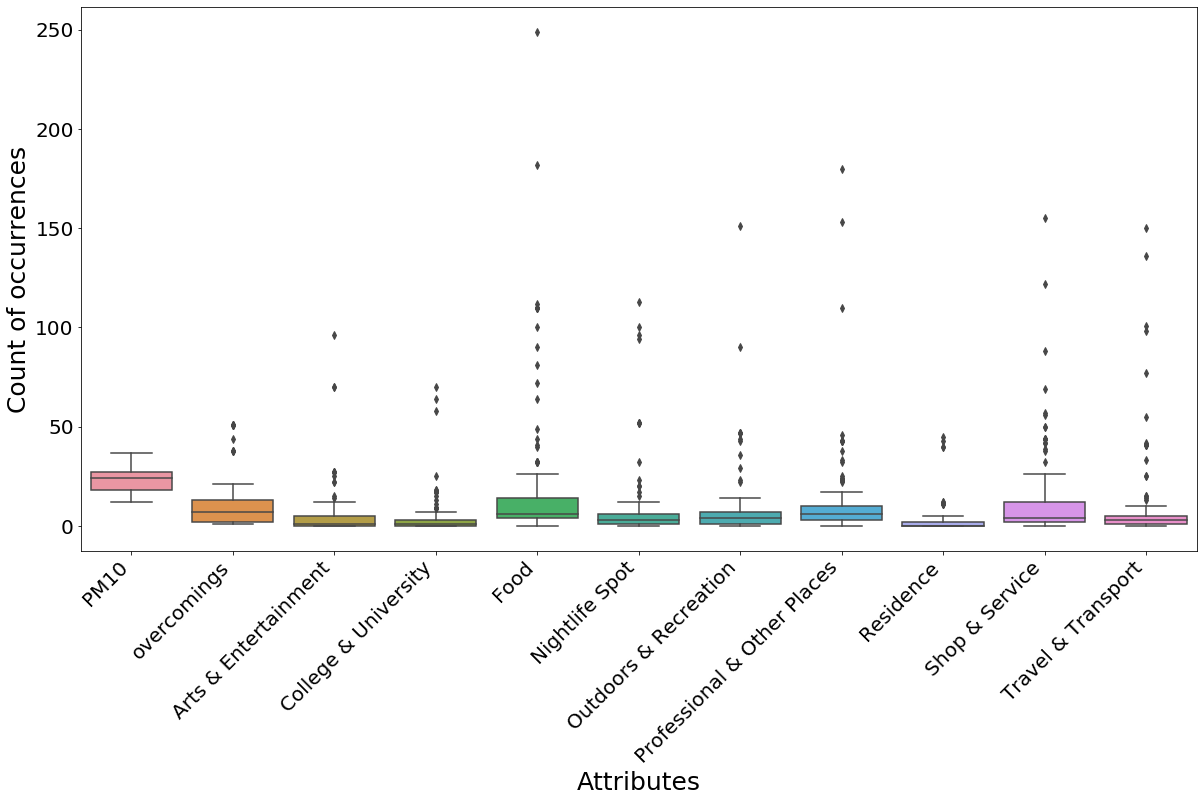

In [466]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

df_stations_copy = df_stations.drop(['population', 'density','latitude','longitude'], axis=1)
ax = sns.boxplot(data = df_stations_copy)
ax.set_ylabel('Count of occurrences', fontsize=25)
ax.set_xlabel('Attributes', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

The most represented venues are Food, Professional and Shops, and all venues present significant upper outliers. PM10 and overcomings are more evenly distributed.

The data is now standardized as a preparation for clustering.

In [469]:
# importing MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

#getting the values to be standardized (excluding name and category)
X = df_stations.values[:,4:]
# applying scaler
scaled_dataset = MinMaxScaler().fit_transform(X)

In [ ]:
# removing the no-more used Event element from the categories list
categories_list.remove(['Event', '4d4b7105d754a06373d81259'])
categories_list

In [471]:
# transforming the scaled dataset in dataframe
scaled_dataframe = pd.DataFrame(scaled_dataset)
# setting the column names again
scaled_dataframe.columns = ['PM10','overcomings', 'population', 'density']+[category[0] for category in categories_list]
scaled_dataframe.head()

,PM10,overcomings,population,density,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.60,0.24,0.077988,0.315315,0.031250,0.085714,0.024096,0.053097,0.052980,0.016667,0.000000,0.019355,0.026667
1,0.60,0.24,0.008011,0.100922,0.072917,0.071429,0.104418,0.053097,0.033113,0.027778,0.022222,0.038710,0.026667
2,0.32,0.04,0.017191,0.013943,0.000000,0.000000,0.008032,0.008850,0.000000,0.000000,0.000000,0.000000,0.006667
3,0.24,0.00,0.011048,0.021557,0.000000,0.014286,0.024096,0.026549,0.006623,0.044444,0.022222,0.025806,0.013333
4,0.24,0.00,0.101453,0.029708,0.000000,0.000000,0.028112,0.035398,0.000000,0.000000,0.000000,0.045161,0.013333


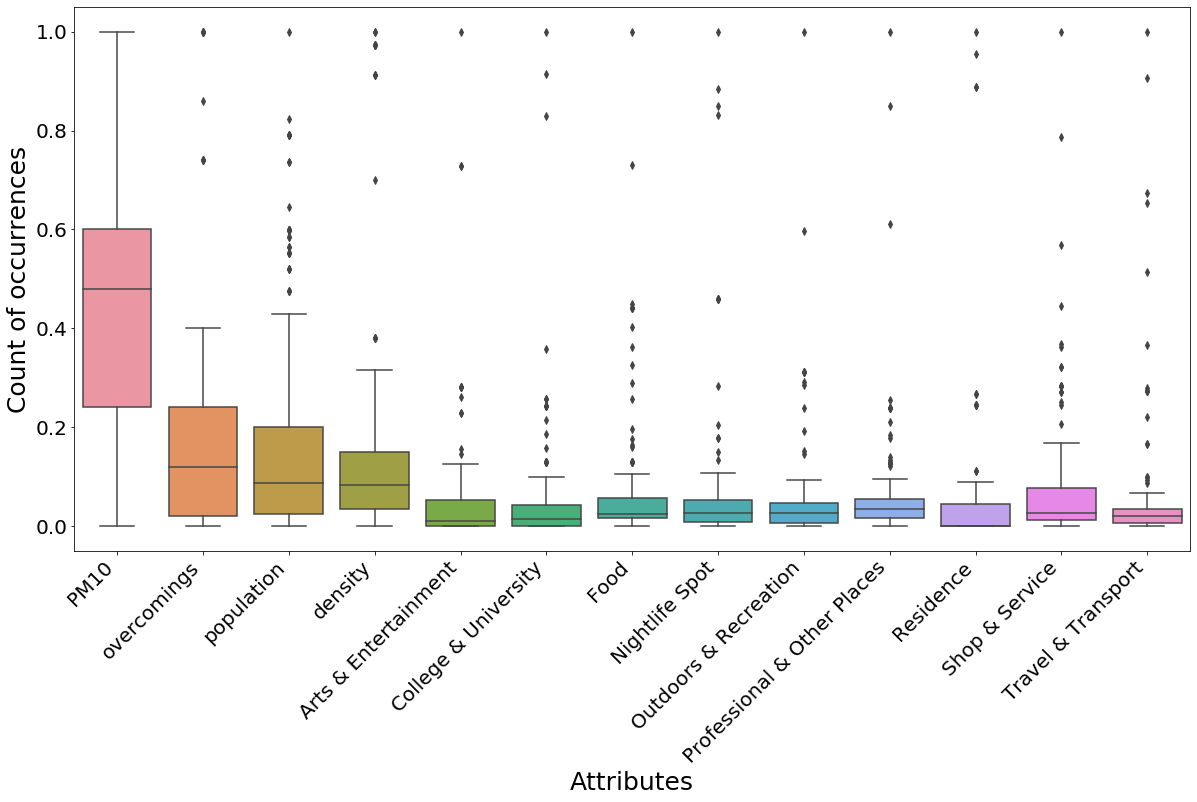

In [472]:
# plotting as before, but with scaled data using pop and density also
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = scaled_dataframe)
ax.set_ylabel('Count of occurrences', fontsize=25)
ax.set_xlabel('Attributes', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

Clustering on 4 clusters, as many as the original categories

In [473]:
# number of clusters
clusters = 4

# performing the k-means clustering
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(scaled_dataframe)

# retrieving the labels
kmeans_labels = kmeans.labels_

# Change label numbers so they go from highest scores to lowest
replace_labels = {0:2, 1:0, 2:3, 3:1}
for i in range(len(kmeans_labels)):
    kmeans_labels[i] = replace_labels[kmeans_labels[i]]

df_stations_clusters_labels = df_stations.copy()
df_stations_clusters_labels['Cluster'] = kmeans_labels
stations_clusters_minmax_df = scaled_dataframe.copy()
stations_clusters_minmax_df['Cluster'] = kmeans_labels
stations_clusters_minmax_df['Nome Stazione/fermata'] = df_stations['Nome Stazione/fermata']
stations_clusters_minmax_df['latitude'] = df_stations['latitude']
stations_clusters_minmax_df['longitude'] = df_stations['longitude']

Showing the characteristics of each cluster

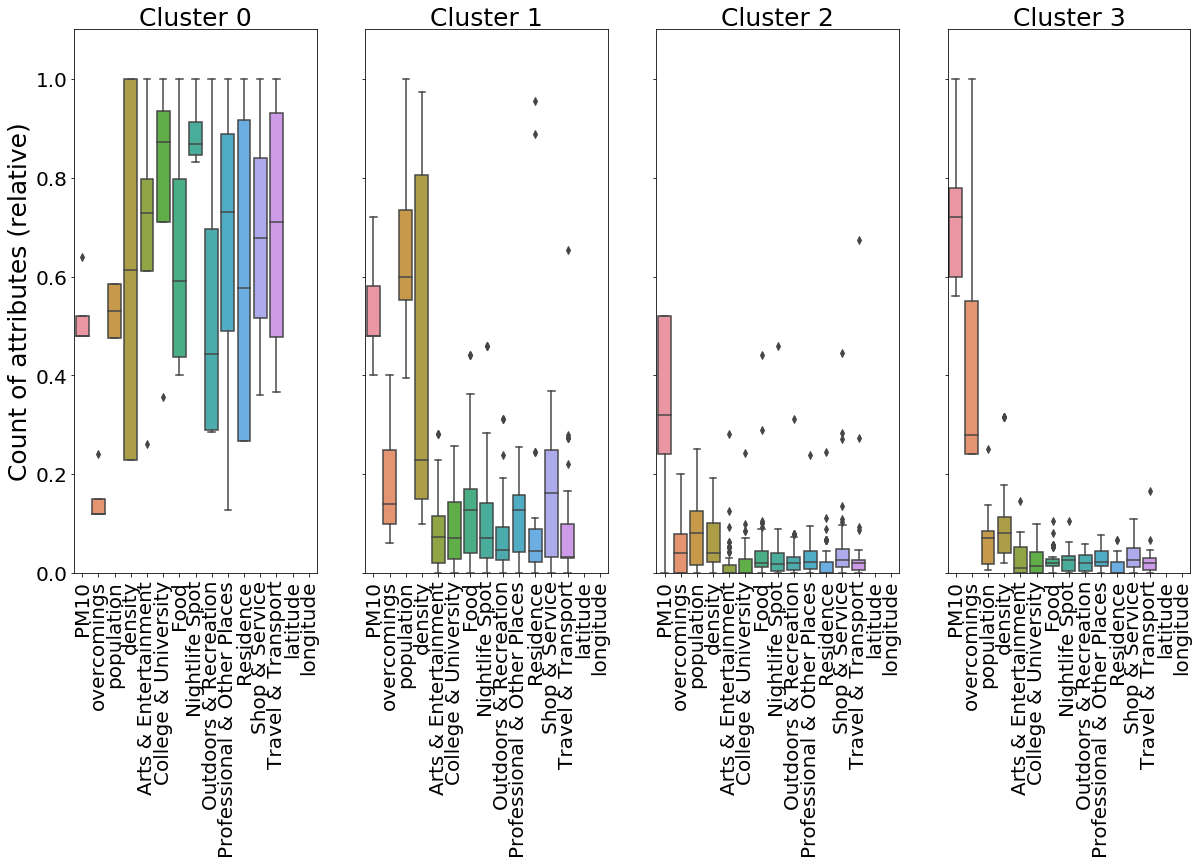

In [476]:
# importing ticker
import matplotlib.ticker as ticker

# creating a figure
fig, axes = plt.subplots(1,clusters, figsize=(20, 10), sharey=True)

# setting y label
axes[0].set_ylabel('Count of attributes (relative)', fontsize=25)

# building the boxes for each cluster
for k in range(clusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    # filling the box with boxplots
    sns.boxplot(data = stations_clusters_minmax_df[stations_clusters_minmax_df['Cluster'] == k].drop('Cluster',1), ax=axes[k])

plt.show()

The first cluster shows an excellent presence in all categories, while the second is significantly below. 
The third and fourth ones have smaller indicators and are differentiated mostly by distribution of venues
and population/pollution differences.

In [481]:
# saving results to excel
df_stations_clusters_labels.to_excel(r'stations_labeled.xls')

In [493]:
#loading labeled stations from the excel

# source filepath
filepath = "stations_labeled.xls"

# populating the dataframe
df_stations = pd.read_excel(filepath)
df_stations = df_stations.drop('Unnamed: 0', axis=1)
df_stations.head(200)

,Nome Stazione/fermata,Categoria,latitude,longitude,PM10,overcomings,population,density,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Cluster,Unnamed: 19
0,ACQUA ACETOSA,3,41.792689,12.620391,27,13,38963,2998,3,6,6,6,8,3,0,3,4,3,0
1,ALBANO LAZIALE,2,41.726437,12.657916,27,13,18574,999,7,5,26,6,5,5,1,6,4,2,0
2,ANAGNI-FIUGGI,2,41.710359,13.096031,20,3,21249,188,0,0,2,1,0,0,0,0,1,2,0
3,ANGUILLARA,2,42.065953,12.293394,18,1,19459,259,0,1,6,3,1,8,1,4,2,2,0
4,ANTRODOCO CENTRO,3,42.410244,13.071053,18,1,45800,335,0,0,7,4,0,0,0,7,2,3,0
5,ANTRODOCO-BORGO VELINO,3,42.410244,13.071053,18,1,45800,335,0,0,7,4,0,0,0,7,2,3,0
6,ANZIO,2,41.452150,12.629295,25,8,55101,1262,4,6,25,4,11,5,2,4,6,2,0
7,ANZIO COLONIA,3,41.460169,12.617093,25,8,55101,1262,1,4,7,7,3,1,1,6,7,3,0
8,APPIANO PROBA PETRONIA,2,41.913542,12.438280,24,8,190513,1451,9,4,90,15,23,25,4,38,42,1,1
9,APRILIA,2,41.592390,12.639172,25,8,74660,419,4,2,15,8,4,6,0,21,6,2,0


In [490]:
# mapping categories to numbers for easier confrontation
mapping = {'PLATINUM': 0, 'GOLD': 1, 'SILVER': 2, 'BRONZE': 3}
df_stations = df_stations.replace({'Categoria': mapping})
df_stations.to_excel(r'stations_labeled.xls')
df_stations.head(200)

,Nome Stazione/fermata,Categoria,latitude,longitude,PM10,overcomings,population,density,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Cluster
0,ACQUA ACETOSA,3,41.792689,12.620391,27,13,38963,2998,3,6,6,6,8,3,0,3,4,3
1,ALBANO LAZIALE,2,41.726437,12.657916,27,13,18574,999,7,5,26,6,5,5,1,6,4,3
2,ANAGNI-FIUGGI,2,41.710359,13.096031,20,3,21249,188,0,0,2,1,0,0,0,0,1,2
3,ANGUILLARA,2,42.065953,12.293394,18,1,19459,259,0,1,6,3,1,8,1,4,2,2
4,ANTRODOCO CENTRO,3,42.410244,13.071053,18,1,45800,335,0,0,7,4,0,0,0,7,2,2
5,ANTRODOCO-BORGO VELINO,3,42.410244,13.071053,18,1,45800,335,0,0,7,4,0,0,0,7,2,2
6,ANZIO,2,41.452150,12.629295,25,8,55101,1262,4,6,25,4,11,5,2,4,6,2
7,ANZIO COLONIA,3,41.460169,12.617093,25,8,55101,1262,1,4,7,7,3,1,1,6,7,2
8,APPIANO PROBA PETRONIA,2,41.913542,12.438280,24,8,190513,1451,9,4,90,15,23,25,4,38,42,1
9,APRILIA,2,41.592390,12.639172,25,8,74660,419,4,2,15,8,4,6,0,21,6,2


In [494]:
# checking for the correctly labeled stations
df_correctly_labeled = df_stations[df_stations['Categoria'] == df_stations['Cluster']]
print(str(len(df_correctly_labeled)) + ' stations out of 165 were correctly labeled')

138 stations out of 165 were correctly labeled


In [496]:
# exploring the uncorrectly labeled stations
df_uncorrectly_labeled = df_stations[df_stations['Categoria'] != df_stations['Cluster']]
df_uncorrectly_labeled = df_uncorrectly_labeled[['Nome Stazione/fermata', 'Categoria', 'Cluster']]
print(str(len(df_uncorrectly_labeled)) + ' stations out of 165 were uncorrectly labeled')
df_uncorrectly_labeled.head(100)

27 stations out of 165 were uncorrectly labeled


,Nome Stazione/fermata,Categoria,Cluster
8,APPIANO PROBA PETRONIA,2,1
13,BAGNI DI TIVOLI,2,3
19,CAPANNELLE,2,1
22,CASSINO,1,2
27,CECCANO,2,3
31,CIAMPINO,1,2
35,CIVITAVECCHIA,1,2
47,FIUMICINO AEROPORTO,1,2
52,FORMIA-GAETA,1,2
57,GEMELLI,2,1


84% of stations matched the original RFI classification.
16% of stations fell into the category immediately below or above.

Showing the map with original RFI classification

In [505]:
# Rome coordinates

latitude = 41.9028
longitude = 12.4964

# creating map
map_rfi = folium.Map(location=[latitude, longitude], zoom_start=9)

# setting color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)] 
colors_array = cm.rainbow(np.linspace(0, 1, len(ys))) 
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding markers to the map
markers_colors = []
for lat, lon, poi, categoria in zip(df_stations['latitude' ], df_stations['longitude'], df_stations['Nome Stazione/fermata'], df_stations['Categoria']):
    label = folium.Popup(str(poi) + ' Categoria ' + str(categoria), parse_html=True)
    if math.isnan(categoria): categoria=5
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label, 
        color=rainbow[int(categoria-1)],
        fill=True,
        fill_color=rainbow[int(categoria-1)],
        fill_opacity=0.7).add_to(map_rfi)
map_rfi
 

Showing the map with original cluster classification

In [504]:
# Rome coordinates

latitude = 41.9028
longitude = 12.4964

# creating map
map_rfi = folium.Map(location=[latitude, longitude], zoom_start=9)

# setting color scheme for the clusters
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)] 
colors_array = cm.rainbow(np.linspace(0, 1, len(ys))) 
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding markers to the map
markers_colors = []
for lat, lon, poi, categoria in zip(df_stations['latitude' ], df_stations['longitude'], df_stations['Nome Stazione/fermata'], df_stations['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(categoria), parse_html=True)
    if math.isnan(categoria): categoria=5
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label, 
        color=rainbow[int(categoria-1)],
        fill=True,
        fill_color=rainbow[int(categoria-1)],
        fill_opacity=0.7).add_to(map_rfi)
map_rfi

## Results and Discussion <a name="results"></a>

Goal of the project was to use data gathered from Foursquare and other sources to classify the stations independently and understand if some stations should deserve a different status from the one given by the network manager (RFI = Rete Ferroviaria Italiana), according to the characteristics of the nearby area.

RFI, in fact, arranged the stations into four categories: Platinum, Gold, Silver and Bronze, depending on the level of services offered in each stations.

The list of the 165 train stations of the Italian region named Lazio was successfully websourced, as well as their addresses. 

Two more datasets were websourced:

1. a list of pollution measuring stations, with average yearly emissions (PM10) and number of days when the maximum threshold has been trespassed (overcomings); these data were used mainly as indicators of traffic;
2. a list of all main neighbourhoods in Lazio, with the overall population and density.

Using Nominatim, the address of the three POIs above were converted into geographical coordinates (longitude and latitude).

After that, a function based on the Vincenty geodesic distance was employed, to associate the closest pollution station and the closest neighbourhood, as well as their data, to each train station.

The final step of the data collection used FourSquare to gather, for each station, the number of venues in a range of 1500 meters, arranged in the FourSquare top 10 categories, that are:

- Arts & Entertainment
- College & University
- Event
- Food
- Nightlife Spot
- Outdoors & Recreation
- Professional & Other Places
- Residence
- Shop & Service
- Travel & Transport

After scaling the data, the K-Means clustering was applied, using a 4 clusters, the same number of the RFI categories.

The visual analysis of the clusters showed a first cluster with an excellent presence in all categories, with the second significantly below. The third and fourth ones had smaller quantities in all venue indicators and were differentiated mostly by distribution of venues and population/pollution differences.

84% of stations matched the original RFI classification. 16% of stations fell into the category immediately below or above. This overall agreement between original categories and computed clusters was shown by visual maps as well.

The stations that were differently classified fell mostly into 2 categories:

1. stations in the centre of Rome, with a venue rich neighbourhood, promoted to the above category (such as Trastevere, S. Pietro, Aurelia, Quattro Venti, Balduina, Monte Mario)
2. stations playing a crucial role as a node in the transportation network, but with poorer neighbourhood, that were demoted to the category immediately below (such as Tiburtina, Fiumicino, Ciampino, Civitavecchia)

Therefore, nothwithstanding the fact that FourSquare Data is un-balanced, with some categories, such as food, over-represented, the clustering made quite sense, with the stations distribution matching broadly the investments made by the network manager on each station, as reflected by the category level.

The non matching labels made sense as well, showing that some stations deserved a higher level than the one suggested by the nearby area, given the strategic position (a close-by airport or harbour), while others should deserve a promotion considering the amount of venues and activities in the nearby area.

## Conclusion <a name="conclusion"></a>

The project made use of websourced data and a non-commercial FourSquare account.

Notwithstanding these limited resources, it proved strong insights into the areas surrounding each station, supporting the choices made by the rail network manager and giving some valuable suggestion.

Further applications could be:

1. exploring the predicted impact of a station promotion/demotion on its reviews;
2. exploring the correlation of check-ins and reviews to other parameters, like availability of certain venues, such as parking or bus stops or restaurants, or the lack of others, such as coworking places or professional structures;
3. the creation of a recommendation system able to advice citizens and tourists about the nearby venues of each station, depending on their needs and past choices of similar users.

The project could be extended to the whole Italian network as well.